# CoLES and numerical characteristics

Same as original CoLES. The amount is normalized during the preprocessing stage. The batch norm is not used.

In [1]:
import pickle

import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
from ptls.preprocessing import PandasDataPreprocessor

In [3]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [4]:
import ptls.data_load
import ptls.data_load.datasets
import ptls.frames
import ptls.frames.coles
import ptls.frames.inference_module
import ptls.nn

In [5]:
import torch

In [6]:
from functools import partial

In [7]:
import pytorch_lightning as pl

In [8]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [9]:
import datetime

In [10]:
def get_norm(df):
    values = torch.cat(df['amount_rur'].values.tolist())
    values = values.sign() * values.abs().log1p()
    m = values.mean().item()
    s = values.std().item()
    return m, s

In [11]:
class LogScaler(ptls.nn.trx_encoder.scalers.IdentityScaler):
    def __init__(self, m, s):
        super().__init__()
        self.m = m
        self.s = s
        
    def forward(self, x):
        x = super().forward(x)
        return (x.abs().log1p() * x.sign() - self.m) / self.s

    @property
    def output_size(self):
        return 1

In [ ]:
# MODEL_NAME='03_coles_softmax_005'
MODEL_NAME='04_coles'

for fold_i in [0, 1, 2, 3, 4]:

    df_trx_pretrain = pd.read_pickle(f'data/fold_{fold_i}/df_trx_pretrain.pickle')
    df_seq_pretrain = pd.read_pickle(f'data/fold_{fold_i}/df_seq_pretrain.pickle')
    df_gbm_train = pd.read_pickle(f'data/fold_{fold_i}/df_gbm_train.pickle')
    df_gbm_test = pd.read_pickle(f'data/fold_{fold_i}/df_gbm_test.pickle')

    with open(f'data/fold_{fold_i}/pdp.pickle', 'rb') as f:
        pdp = pickle.load(f)
        

    df_seq_pretrain_train, df_seq_pretrain_valid = train_test_split(
        df_seq_pretrain, test_size=0.05, shuffle=True, random_state=42)

    len(df_seq_pretrain_train), len(df_seq_pretrain_valid)

    coles_data_module = ptls.frames.PtlsDataModule(
        train_data=ptls.frames.coles.ColesDataset(
            data=ptls.data_load.datasets.MemoryMapDataset(
                df_seq_pretrain_train.to_dict(orient='records') + 
                df_trx_pretrain.to_dict(orient='records')
            ),
            splitter=ptls.frames.coles.split_strategy.SampleSlices(
                split_count=5,
                cnt_min=25,
                cnt_max=200,
            ),
        ),
        valid_data=ptls.frames.coles.ColesDataset(
            data=ptls.data_load.datasets.MemoryMapDataset(
                df_seq_pretrain_train.to_dict(orient='records')),
            splitter=ptls.frames.coles.split_strategy.SampleSlices(
                split_count=5,
                cnt_min=25,
                cnt_max=100,
            ),
        ),
        train_batch_size=64,
        train_num_workers=4,
        valid_batch_size=650,
    )

    pl_coles_module = ptls.frames.coles.CoLESModule(
        validation_metric=ptls.frames.coles.metric.BatchRecallTopK(
            K=4,
            metric='cosine',
        ),
        seq_encoder=torch.nn.Sequential(
            ptls.nn.TrxEncoder(
                norm_embeddings=False,
                embeddings_noise=0.003,
                use_batch_norm=False,
                embeddings={
                    'weekday': {'in': 10, 'out': 8},
                    'small_group': {'in': 250, 'out': 16},
                    'event_time': {'in': 800, 'out': 8},
                },
                numeric_values={ 
                    # 'amount_rur': 'identity',
                    # 'amount_rur': 'log',
                    'amount_rur': LogScaler(*get_norm(df_seq_pretrain_train)),
                },
            ),
            ptls.nn.RnnEncoder(
                # input_size=25,
                input_size=33,
                type='gru',
                hidden_size=800,
                is_reduce_sequence=True,
            ),
        ),
        head=ptls.nn.Head(use_norm_encoder=True),
        loss=ptls.frames.coles.losses.ContrastiveLoss(
            margin=0.5,
            sampling_strategy=ptls.frames.coles.sampling_strategies.HardNegativePairSelector(
              neg_count=5,
            ),
        ),
        # loss=ptls.frames.coles.losses.SoftmaxLoss(
        #     temperature=0.05,
        # ),
        optimizer_partial=partial(torch.optim.Adam, lr=0.001, weight_decay=0.0),
        lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9025)
    )

    trainer = pl.Trainer(
        gpus=1,
        max_epochs=150, # 150,
        enable_checkpointing=False,
        enable_progress_bar=False,
        gradient_clip_val=0.5,
        gradient_clip_algorithm="value",    
    )   

    pretrain_logger_version = trainer.logger.version
    print(f'pretrain_logger_version = {pretrain_logger_version}')
    trainer.fit(pl_coles_module, coles_data_module)

    inference_dl_gbm_train = torch.utils.data.DataLoader(
        dataset=ptls.data_load.datasets.MemoryMapDataset(
            df_gbm_train.to_dict(orient='records'),
            i_filters=[
                ptls.data_load.iterable_processing.ISeqLenLimit(max_seq_len=2000), 
            ],
        ),
        collate_fn=ptls.data_load.utils.collate_feature_dict,
        shuffle=False,
        batch_size=1000,
        num_workers=12,
    )

    inference_dl_gbm_test = torch.utils.data.DataLoader(
        dataset=ptls.data_load.datasets.MemoryMapDataset(
            df_gbm_test.to_dict(orient='records'),
            i_filters=[
                ptls.data_load.iterable_processing.ISeqLenLimit(max_seq_len=2000), 
            ],
        ),
        collate_fn=ptls.data_load.utils.collate_feature_dict,
        shuffle=False,
        batch_size=1000,
        num_workers=12,
    )

    inf_model = ptls.frames.inference_module.InferenceModule(
        model=pl_coles_module.seq_encoder, pandas_output=True, model_out_name='emb')

    predict_gbm_train = pl.Trainer(gpus=1, enable_progress_bar=False, logger=None)\
    .predict(inf_model, inference_dl_gbm_train)

    predict_gbm_test = pl.Trainer(gpus=1, enable_progress_bar=False, logger=None)\
    .predict(inf_model, inference_dl_gbm_test)

    predict_gbm_train = pd.concat(predict_gbm_train, axis=0)

    predict_gbm_test = pd.concat(predict_gbm_test, axis=0)

    predict_gbm_train.set_index('client_id', inplace=True)
    predict_gbm_test.set_index('client_id', inplace=True)

    gbm_model = LGBMClassifier(**{
          'n_estimators': 1000,
          'boosting_type': 'gbdt',
          'objective': 'multiclass',
          'num_class': 4,
          'metric': 'multi_error',
          'learning_rate': 0.02,
          'subsample': 0.75,
          'subsample_freq': 1,
          'feature_fraction': 0.75,
          'colsample_bytree': None,
          'max_depth': 12,
          'lambda_l1': 1,
          'reg_alpha': None,
          'lambda_l2': 1,
          'reg_lambda': None,
          'min_data_in_leaf': 50,
          'min_child_samples': None,
          'num_leaves': 50,
          'random_state': 42,
          'n_jobs': 4,
    })

    gbm_model.fit(predict_gbm_train.drop(columns='bins'), predict_gbm_train['bins'])

    acc = accuracy_score(
        gbm_model.predict(predict_gbm_test.drop(columns='bins')), 
        predict_gbm_test['bins'],
    )
    acc

    with open('results.log', 'at') as f:
        print('\t'.join([
            MODEL_NAME,
            f'{datetime.datetime.now():%Y-%m-%d %H:%M:%S}',
            f'{fold_i}',
            'accuracy',
            f'{acc:.4f}',
            f'{pretrain_logger_version}',
    ]), file=f)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


pretrain_logger_version = 129


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | Sequential      | 2.0 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.061     Total estimated model params size (MB)
/home/jovyan/.local/share/virtualenvs/ptls-experiments-Evn9g0Hu/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:92: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

pretrain_logger_version = 131


In [14]:
df_res = pd.read_csv(
    # 'results.log',
    'results-amount.log',
    sep='\t', header=None,
    names=['model', 'time', 'fold_i', 'metric', 'value', 'pretrain_logger_version']
)
df_res.tail(10)

,model,time,fold_i,metric,value,pretrain_logger_version
8,02_coles_orig,2024-01-19 12:03:27,2,accuracy,0.6358,56
9,02_coles_orig,2024-01-19 12:03:33,4,accuracy,0.6340,58
10,03_coles_no_amount,2024-01-27 03:12:28,0,accuracy,0.6178,117
11,03_coles_no_amount,2024-01-27 07:01:46,1,accuracy,0.6227,119
12,03_coles_no_amount,2024-01-27 10:52:42,2,accuracy,0.6112,121
13,03_coles_logms_amout,2024-01-27 23:38:20,0,accuracy,0.6407,129
14,03_coles_logms_amout,2024-01-28 03:33:08,1,accuracy,0.6448,131
15,03_coles_logms_amout,2024-01-28 07:28:58,2,accuracy,0.6408,133
16,03_coles_logms_amout,2024-01-28 11:26:03,3,accuracy,0.6403,134
17,03_coles_logms_amout,2024-01-28 15:26:44,4,accuracy,0.6367,135


In [15]:
df_res.groupby('model')['value'].agg(['mean', 'std', lambda x: sorted(x)])

,mean,std,<lambda_0>
model,,,
02_agg_baseline,0.632480,0.003163,"[0.629, 0.6297, 0.6325, 0.635, 0.6362]"
02_coles_orig,0.639380,0.004827,"[0.634, 0.6358, 0.6387, 0.6427, 0.6457]"
03_coles_logms_amout,0.640660,0.002871,"[0.6367, 0.6403, 0.6407, 0.6408, 0.6448]"
03_coles_no_amount,0.617233,0.005771,"[0.6112, 0.6178, 0.6227]"


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

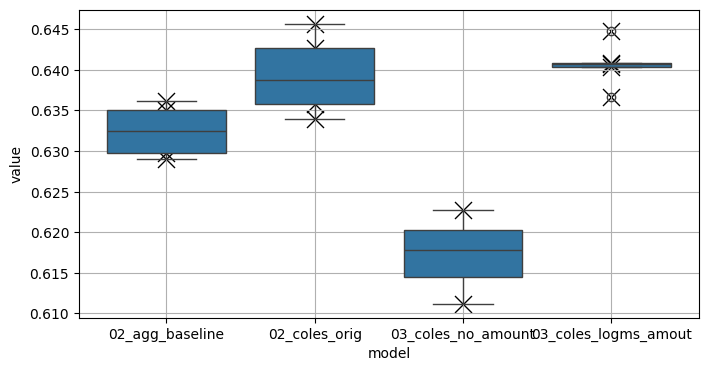

In [18]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.boxplot(
    data=df_res[lambda x: ~x['model'].isin(['02_coles_0'])],
    x='model',
    y='value',
)
sns.scatterplot(
    data=df_res[lambda x: ~x['model'].isin(['02_coles_0'])],
    x='model',
    y='value',
    marker="x",
    c='k',
    s=150,
)

plt.grid()
plt.show()